# Music Genre Classification

We will explore the training data and build a model to classify a music sample by its genre. We will be following [this article by Arsh Chowdhry on Medium|Clairvoyant](https://blog.clairvoyantsoft.com/music-genre-classification-using-cnn-ef9461553726). 

## 1. Problem Definition

Given a music sample, we want to know if we can identify what genre it belongs to.

## 2. Data

The [original dataset (GTZAN Dataset - Music Genre Classification)](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification/activity) was taken from Kaggle.

## 3. Evaluation

We will be aiming for a 90% accuracy for this model, since it is not meant to be used for high-precision-demanding purposes. We will be evaluate if the model predicts the correct value for the target variable. The possible values of the genre are:

1. Blues
2. Classical
3. Country
4. Disco
5. Hip-hop
6. Jazz
7. Metal
8. Pop
9. Reggae
10. Rock

## Exploratory Data Analysis

### Importing Libraries

In [1]:
import sys
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from tensorflow import keras as k

import warnings
warnings.filterwarnings("ignore") # Sorry :(

ORANGE = "#f78838"
MAGENTA = '#db2a0f'

### Reading the data

In [2]:
df = pd.read_csv('./data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [3]:
df.shape

(9990, 60)

In [4]:
df.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [5]:
df = df.drop(labels="filename", axis=1)

In [6]:
audio_recording = "./data/genres_original/country/country.00050.wav"

# sr = "Sampling Rate" (Number of samples per second).
data, sr = librosa.load(audio_recording) # Load and decode the audio as a time series y.
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [7]:
librosa.load(audio_recording, sr=45600)

(array([ 0.04582627,  0.06254332,  0.0583379 , ..., -0.13857861,
        -0.11823352, -0.05911855], dtype=float32),
 45600)

### Visualizing audio file

#### Wave Files

- x-axis = time
- y-axis = amplitude

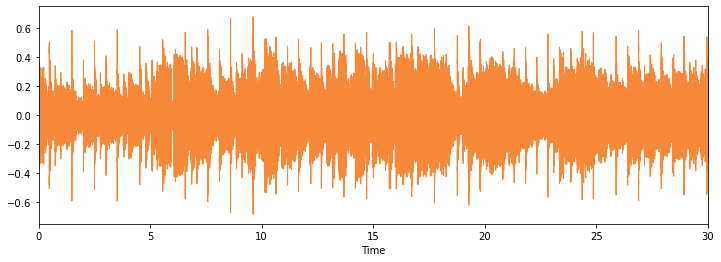

In [8]:
plt.figure(figsize=(12,4))
librosa.display.waveplot(data, color=ORANGE)
plt.show()

#### Spectograms

Signal loudness of a signal over time at various frequencies present in a particular waveform.

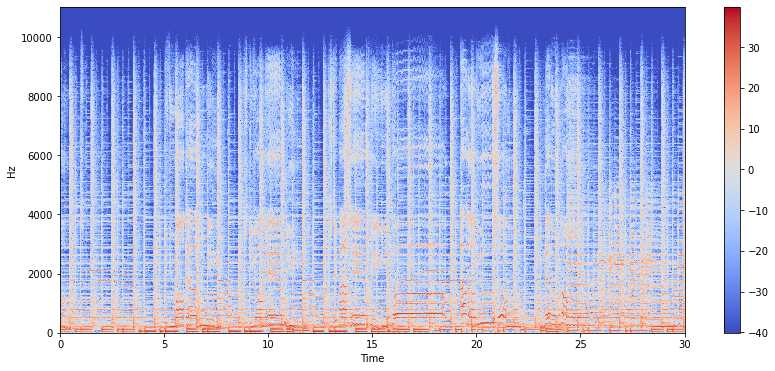

In [12]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14, 6))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

#### Spectral Rollof

Frequency below which a specified percentage of the total spectral energy, e.g. 85%.

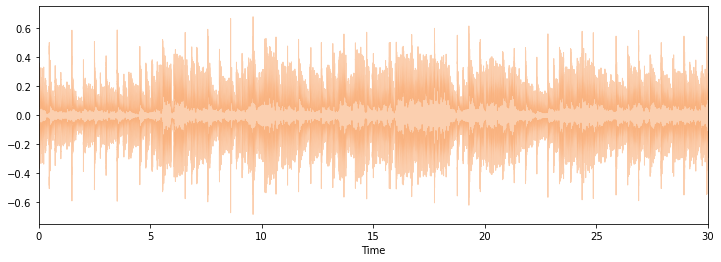

In [13]:
from sklearn.preprocessing import normalize
spectral_rollof = librosa.feature.spectral_rolloff(data+0.01, sr=sr)[0]
plt.figure(figsize=(12,4))
librosa.display.waveplot(data, sr=sr, alpha=0.4, color = ORANGE)

#### Chroma Feature

> "Capture harmonica and melodic characteristics of music while being robust to changes in timbre and instrumentation."

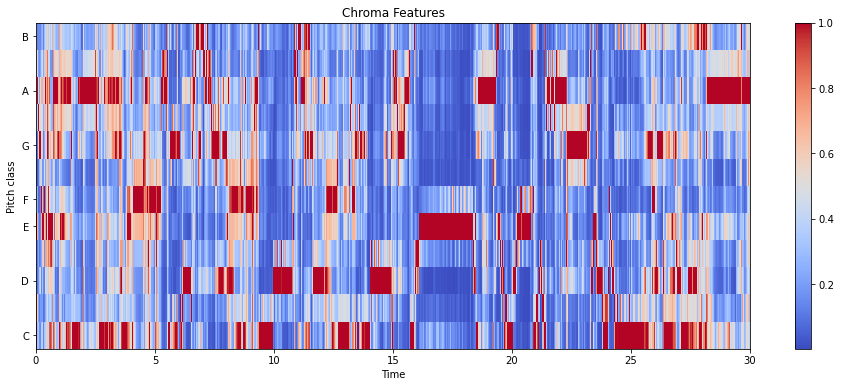

In [14]:
import librosa.display as lplt
chroma = librosa.feature.chroma_stft(data, sr=sr)
plt.figure(figsize=(16, 6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Chroma Features')
plt.show()

#### Zero Crossing Rate

> Zero crossing is said to occur if successive samples have different algebraic signs. THe rate at which zero-crossing occur is a simple measure of the frequency content of a signal. Zero-crossing rate is a measure of the number of times in a given time interval/frame that the amplitude of the speech signals passes through a value of zero.

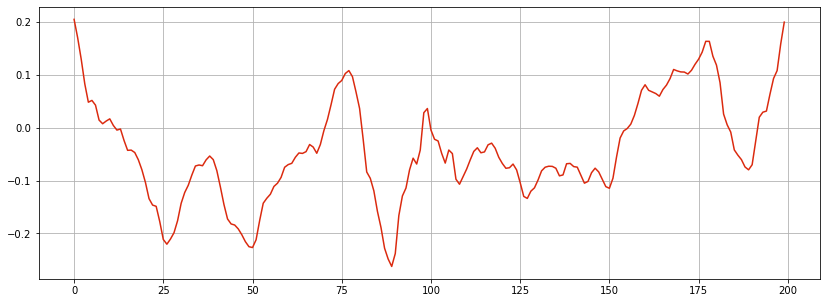

In [15]:
start, end = 1000, 1200

plt.figure(figsize=(14, 5))
plt.plot(data[start:end], color=MAGENTA)
plt.grid()

In [16]:
zero_cross_rate = librosa.zero_crossings(data[start:end], pad=False)
print("The number of zero-crossings is :", sum(zero_cross_rate))

The number of zero-crossings is : 8


### Feature Extraction

To convert categorical text data into numerical, we will use the Label Encoder class.

In [17]:
class_list = df.iloc[:, -1]
convertor = LabelEncoder()

In [18]:
y = convertor.fit_transform(class_list) # Fit label encoder and return encoded labels
y

array([0, 0, 0, ..., 9, 9, 9])

In [19]:
print((df.iloc[:, :-1]))

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

### Scaling the Features

We will use a standard scaler for the features, by removing the mean and scaling to unit variance.

The standard score for the sample `x` is calculated as:

![equation](https://latex.codecogs.com/svg.image?z&space;=&space;(x&space;-&space;u)/s)

In [20]:
from sklearn.preprocessing import StandardScaler

fit = StandardScaler()
X = fit.fit_transform(np.array(df.iloc[:, :-1], dtype=float))

### Dividing data intro Training and Testing Sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
len(y_train), len(y_test)

(6693, 3297)

### Building the model

We will use a Convoluted Neural Network (CNN) Algorithn to train our model. Previous works have proved its efficiency for this kind of problem, and here is a comparison with other ml algorithms:

![Table: CNN compared to other models](https://miro.medium.com/max/1400/0*thoVr8NTv62uSQPL)

In [22]:
from keras.models import Sequential

Using TensorFlow backend.


In [29]:
def train_model(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])
    return model.fit(X_train,
                     y_train,
                     validation_data=(X_test, y_test),
                     epochs=epochs,
                     batch_size=batch_size
                    )

In [30]:
def plot_validate(history):
    print("Validation Accuracy", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=[12, 6])
    plt.show()

In [31]:
model = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),   
    
    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),   
    
    k.layers.Dense(10, activation='softmax'),
])
print(model.summary())
model_history = train_model(model=model, epochs=600, optimizer='adam')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               30208     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

6693/6693 [==============================] - 1s 143us/sample - loss: 0.0616 - accuracy: 0.9800 - val_loss: 0.4293 - val_accuracy: 0.8981
Epoch 46/600
6693/6693 [==============================] - 1s 157us/sample - loss: 0.0588 - accuracy: 0.9810 - val_loss: 0.4289 - val_accuracy: 0.8960
Epoch 47/600
6693/6693 [==============================] - 1s 149us/sample - loss: 0.0578 - accuracy: 0.9819 - val_loss: 0.4294 - val_accuracy: 0.8996
Epoch 48/600
6693/6693 [==============================] - 1s 151us/sample - loss: 0.0782 - accuracy: 0.9746 - val_loss: 0.4145 - val_accuracy: 0.9026
Epoch 49/600
6693/6693 [==============================] - 1s 150us/sample - loss: 0.0708 - accuracy: 0.9762 - val_loss: 0.4020 - val_accuracy: 0.9008
Epoch 50/600
6693/6693 [==============================] - 1s 145us/sample - loss: 0.0740 - accuracy: 0.9756 - val_loss: 0.3976 - val_accuracy: 0.9008
Epoch 51/600
6693/6693 [==============================] - 1s 145us/sample - loss: 0.0671 - accuracy: 0.9792 - val

Epoch 100/600
6693/6693 [==============================] - 1s 129us/sample - loss: 0.0420 - accuracy: 0.9858 - val_loss: 0.4376 - val_accuracy: 0.9090
Epoch 101/600
6693/6693 [==============================] - 1s 129us/sample - loss: 0.0375 - accuracy: 0.9873 - val_loss: 0.4253 - val_accuracy: 0.9072
Epoch 102/600
6693/6693 [==============================] - 1s 129us/sample - loss: 0.0331 - accuracy: 0.9892 - val_loss: 0.4521 - val_accuracy: 0.9084
Epoch 103/600
6693/6693 [==============================] - 1s 130us/sample - loss: 0.0364 - accuracy: 0.9877 - val_loss: 0.4341 - val_accuracy: 0.9117
Epoch 104/600
6693/6693 [==============================] - 1s 130us/sample - loss: 0.0357 - accuracy: 0.9885 - val_loss: 0.4360 - val_accuracy: 0.9075
Epoch 105/600
6693/6693 [==============================] - 1s 129us/sample - loss: 0.0358 - accuracy: 0.9879 - val_loss: 0.4357 - val_accuracy: 0.9072
Epoch 106/600
6693/6693 [==============================] - 1s 129us/sample - loss: 0.0355 - ac

6693/6693 [==============================] - 1s 124us/sample - loss: 0.0262 - accuracy: 0.9916 - val_loss: 0.4384 - val_accuracy: 0.9196
Epoch 155/600
6693/6693 [==============================] - 1s 124us/sample - loss: 0.0284 - accuracy: 0.9915 - val_loss: 0.4519 - val_accuracy: 0.9123
Epoch 156/600
6693/6693 [==============================] - 1s 124us/sample - loss: 0.0265 - accuracy: 0.9912 - val_loss: 0.4398 - val_accuracy: 0.9123
Epoch 157/600
6693/6693 [==============================] - 1s 125us/sample - loss: 0.0278 - accuracy: 0.9904 - val_loss: 0.4656 - val_accuracy: 0.9078
Epoch 158/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0352 - accuracy: 0.9883 - val_loss: 0.4355 - val_accuracy: 0.9117
Epoch 159/600
6693/6693 [==============================] - 1s 127us/sample - loss: 0.0230 - accuracy: 0.9924 - val_loss: 0.4716 - val_accuracy: 0.9102
Epoch 160/600
6693/6693 [==============================] - 1s 122us/sample - loss: 0.0253 - accuracy: 0.9925

6693/6693 [==============================] - 1s 138us/sample - loss: 0.0246 - accuracy: 0.9921 - val_loss: 0.4460 - val_accuracy: 0.9145
Epoch 209/600
6693/6693 [==============================] - 1s 138us/sample - loss: 0.0223 - accuracy: 0.9930 - val_loss: 0.4521 - val_accuracy: 0.9166
Epoch 210/600
6693/6693 [==============================] - 1s 140us/sample - loss: 0.0148 - accuracy: 0.9957 - val_loss: 0.4690 - val_accuracy: 0.9142
Epoch 211/600
6693/6693 [==============================] - 1s 145us/sample - loss: 0.0190 - accuracy: 0.9943 - val_loss: 0.4867 - val_accuracy: 0.9136
Epoch 212/600
6693/6693 [==============================] - 1s 137us/sample - loss: 0.0272 - accuracy: 0.9916 - val_loss: 0.4598 - val_accuracy: 0.9151
Epoch 213/600
6693/6693 [==============================] - 1s 138us/sample - loss: 0.0190 - accuracy: 0.9934 - val_loss: 0.4510 - val_accuracy: 0.9199
Epoch 214/600
6693/6693 [==============================] - 1s 139us/sample - loss: 0.0145 - accuracy: 0.9951

6693/6693 [==============================] - 1s 133us/sample - loss: 0.0199 - accuracy: 0.9928 - val_loss: 0.4116 - val_accuracy: 0.9202
Epoch 263/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0199 - accuracy: 0.9931 - val_loss: 0.4479 - val_accuracy: 0.9233
Epoch 264/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0188 - accuracy: 0.9936 - val_loss: 0.4255 - val_accuracy: 0.9178
Epoch 265/600
6693/6693 [==============================] - 1s 132us/sample - loss: 0.0157 - accuracy: 0.9948 - val_loss: 0.4519 - val_accuracy: 0.9199
Epoch 266/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0173 - accuracy: 0.9939 - val_loss: 0.4251 - val_accuracy: 0.9251
Epoch 267/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0202 - accuracy: 0.9940 - val_loss: 0.4567 - val_accuracy: 0.9260
Epoch 268/600
6693/6693 [==============================] - 1s 132us/sample - loss: 0.0169 - accuracy: 0.9946

6693/6693 [==============================] - 1s 138us/sample - loss: 0.0230 - accuracy: 0.9927 - val_loss: 0.5035 - val_accuracy: 0.9233
Epoch 317/600
6693/6693 [==============================] - 1s 137us/sample - loss: 0.0146 - accuracy: 0.9943 - val_loss: 0.4833 - val_accuracy: 0.9230
Epoch 318/600
6693/6693 [==============================] - 1s 137us/sample - loss: 0.0111 - accuracy: 0.9963 - val_loss: 0.4842 - val_accuracy: 0.9254
Epoch 319/600
6693/6693 [==============================] - 1s 136us/sample - loss: 0.0125 - accuracy: 0.9954 - val_loss: 0.5085 - val_accuracy: 0.9272
Epoch 320/600
6693/6693 [==============================] - 1s 140us/sample - loss: 0.0172 - accuracy: 0.9936 - val_loss: 0.5133 - val_accuracy: 0.9230
Epoch 321/600
6693/6693 [==============================] - 1s 137us/sample - loss: 0.0194 - accuracy: 0.9937 - val_loss: 0.4740 - val_accuracy: 0.9260
Epoch 322/600
6693/6693 [==============================] - 1s 137us/sample - loss: 0.0266 - accuracy: 0.9924

6693/6693 [==============================] - 1s 133us/sample - loss: 0.0115 - accuracy: 0.9972 - val_loss: 0.4901 - val_accuracy: 0.9233
Epoch 371/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0067 - accuracy: 0.9976 - val_loss: 0.5121 - val_accuracy: 0.9211
Epoch 372/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0136 - accuracy: 0.9952 - val_loss: 0.4956 - val_accuracy: 0.9245
Epoch 373/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0227 - accuracy: 0.9937 - val_loss: 0.5125 - val_accuracy: 0.9199
Epoch 374/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0204 - accuracy: 0.9940 - val_loss: 0.4611 - val_accuracy: 0.9230
Epoch 375/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0170 - accuracy: 0.9955 - val_loss: 0.4731 - val_accuracy: 0.9257
Epoch 376/600
6693/6693 [==============================] - 1s 132us/sample - loss: 0.0149 - accuracy: 0.9952

6693/6693 [==============================] - 1s 137us/sample - loss: 0.0134 - accuracy: 0.9972 - val_loss: 0.5010 - val_accuracy: 0.9254
Epoch 425/600
6693/6693 [==============================] - 1s 171us/sample - loss: 0.0109 - accuracy: 0.9963 - val_loss: 0.4756 - val_accuracy: 0.9266
Epoch 426/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.5102 - val_accuracy: 0.9239
Epoch 427/600
6693/6693 [==============================] - 1s 135us/sample - loss: 0.0097 - accuracy: 0.9966 - val_loss: 0.4944 - val_accuracy: 0.9293
Epoch 428/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0148 - accuracy: 0.9958 - val_loss: 0.5606 - val_accuracy: 0.9233
Epoch 429/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0169 - accuracy: 0.9930 - val_loss: 0.5139 - val_accuracy: 0.9227
Epoch 430/600
6693/6693 [==============================] - 1s 134us/sample - loss: 0.0176 - accuracy: 0.9952

6693/6693 [==============================] - 1s 137us/sample - loss: 0.0179 - accuracy: 0.9960 - val_loss: 0.4591 - val_accuracy: 0.9248
Epoch 479/600
6693/6693 [==============================] - 1s 138us/sample - loss: 0.0161 - accuracy: 0.9946 - val_loss: 0.4755 - val_accuracy: 0.9214
Epoch 480/600
6693/6693 [==============================] - 1s 137us/sample - loss: 0.0077 - accuracy: 0.9972 - val_loss: 0.4947 - val_accuracy: 0.9245
Epoch 481/600
6693/6693 [==============================] - 1s 138us/sample - loss: 0.0123 - accuracy: 0.9958 - val_loss: 0.4737 - val_accuracy: 0.9260
Epoch 482/600
6693/6693 [==============================] - 1s 137us/sample - loss: 0.0111 - accuracy: 0.9961 - val_loss: 0.5159 - val_accuracy: 0.9245
Epoch 483/600
6693/6693 [==============================] - 1s 137us/sample - loss: 0.0063 - accuracy: 0.9979 - val_loss: 0.5504 - val_accuracy: 0.9205
Epoch 484/600
6693/6693 [==============================] - 1s 137us/sample - loss: 0.0106 - accuracy: 0.9969

6693/6693 [==============================] - 1s 136us/sample - loss: 0.0118 - accuracy: 0.9963 - val_loss: 0.5420 - val_accuracy: 0.9205
Epoch 533/600
6693/6693 [==============================] - 1s 137us/sample - loss: 0.0193 - accuracy: 0.9952 - val_loss: 0.5506 - val_accuracy: 0.9178
Epoch 534/600
6693/6693 [==============================] - 1s 140us/sample - loss: 0.0123 - accuracy: 0.9952 - val_loss: 0.4816 - val_accuracy: 0.9233
Epoch 535/600
6693/6693 [==============================] - 1s 139us/sample - loss: 0.0110 - accuracy: 0.9963 - val_loss: 0.5320 - val_accuracy: 0.9202
Epoch 536/600
6693/6693 [==============================] - 1s 142us/sample - loss: 0.0119 - accuracy: 0.9955 - val_loss: 0.5372 - val_accuracy: 0.9214
Epoch 537/600
6693/6693 [==============================] - 1s 143us/sample - loss: 0.0073 - accuracy: 0.9970 - val_loss: 0.5278 - val_accuracy: 0.9193
Epoch 538/600
6693/6693 [==============================] - 1s 142us/sample - loss: 0.0126 - accuracy: 0.9961

6693/6693 [==============================] - 1s 133us/sample - loss: 0.0076 - accuracy: 0.9967 - val_loss: 0.5547 - val_accuracy: 0.9211
Epoch 587/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0135 - accuracy: 0.9967 - val_loss: 0.4860 - val_accuracy: 0.9263
Epoch 588/600
6693/6693 [==============================] - 1s 134us/sample - loss: 0.0105 - accuracy: 0.9964 - val_loss: 0.5067 - val_accuracy: 0.9233
Epoch 589/600
6693/6693 [==============================] - 1s 133us/sample - loss: 0.0129 - accuracy: 0.9967 - val_loss: 0.5678 - val_accuracy: 0.9175
Epoch 590/600
6693/6693 [==============================] - 1s 132us/sample - loss: 0.0116 - accuracy: 0.9960 - val_loss: 0.5452 - val_accuracy: 0.9199
Epoch 591/600
6693/6693 [==============================] - 1s 132us/sample - loss: 0.0161 - accuracy: 0.9963 - val_loss: 0.5248 - val_accuracy: 0.9181
Epoch 592/600
6693/6693 [==============================] - 1s 134us/sample - loss: 0.0096 - accuracy: 0.9969

### Model Evaluation

In [32]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=128)
print(f"The test loss is : {test_loss}")
print(f"The Best test Accuracy is : {test_acc*100}")

3297/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

The test loss is : 0.499724087089273
The Best test Accuracy is : 92.26569533348083


In [ ]:
model.predict